In [1]:
# Kernel crashes if matplotlib not initialized
import matplotlib
matplotlib.use('nbagg')

from dataccess.nbfunctions import *
from dataccess.summarymetrics import plt, histogram, scatter
from dataccess import mec
from scipy import stats
%pdb

Automatic pdb calling has been turned ON


In [2]:
from dataccess import peakfinder


def peakfilter_frame2(arr, detid = None, window_min = 0, radius = 4, thr_low = 20, thr_high = 50):
    """
    Mutates arr.
    """
    def filtfunc2(arr):
        base = 0#np.median(arr)
        return peakfinder.consolidate_peaks(arr, thr_low = thr_low, thr_high = thr_high, radius = radius)
    def process_island2(subarr):
        subarr[:] -= np.percentile(subarr, 20)
        subarr[:] = filtfunc2(subarr)
        return subarr
    
    if detid == 'quad2':
        clusters = clusters2
    elif detid == 'quad1':
        clusters = clusters1
    elif detid == 'si':
        return arr
    else:
        raise ValueError
    subregions = clustermap(arr, clusters, process_island2)
    for cluster, subarr in zip(clusters, subregions):
        bounding_view(arr, cluster)[:] = subarr
    arr[arr < window_min] = 0
    return arr

%run ../masks/masks.py
mask2 = np.load('../masks/quad2_mask_10.11.npy')
mask1 = np.load('../masks/quad1_mask_10.11.npy')
arr1, clusters1 = find_islands(mask1, 0, 1000)
arr2, clusters2 = find_islands(mask2, 0, 1000)

In [3]:
# Exclude run 923 from the 58 um dataset due to its high number of events with zero signal
MgO_ref_short_clean = [get_query_dataset('material MgO runs 870 961 transmission 1. focal_size %d' % spotsize,
                                'MgO.ref.1C.short2.%sum' % spotsize, print_enable = False)
                                for spotsize in [2, 4, 8, 18, 38, 48]] + [query.DataSet([922], label = 'r922')]
ds = MgO_ref_short_clean[-2]
ds2 = MgO_ref_short_clean[0]

In [4]:
def my_200_array(arr, bgsub = False, **kwargs):
    dss = xrd.Pattern.from_dataset(arr, 'quad2', ['MgO'], label  = 'test')
    return dss.peak_sizes()[1]

#def my_200_array(arr, bgsub = False, **kwargs):
#    dss = xrd.Pattern.from_dataset(arr, 'quad2', ['MgO'], label  = 'test')
#    return dss.peak_sizes()

In [5]:
#def my_200(ds):
#    dss = xrd.Dataset(ds, '', ['quad2'], ['MgO'])
#    angles, intensities, _ = xrd.process_dataset(dss)
#    return xrd.peak_sizes(angles, intensities, dss.compound_list[0])[1]

#def my_200_array(arr, bgsub = False, **kwargs):
#    dss = xrd.XRDset(arr, 'array', ['quad2'], ['MgO'], label = 'arr')
#    angles, intensities, _ = xrd.process_dataset(dss, bgsub = bgsub)
#    return xrd.peak_sizes(angles, intensities, dss.compound_list[0])[1]

## Scatterplot of $I_{200}$ vs. $I_0$ for MgO, short pulse duration, 2-58 um focal spot size:

In [5]:
def i220_i0_correlation_scatter(ds, plot = True, show = True, frame_processor = None):
    scatter_ds = scatter(ds, ('si', mec.si_imarr_sum), ('quad2', my_200_array), plot = plot,
                         show = show, frame_processor = peakfilter_frame2)
    slope, intercept, r_value, p_value, std_err = stats.linregress(*scatter_ds)
    print zip(['slope', 'intercept', 'r_value', 'p_value', 'std_err'], [slope, intercept, r_value, p_value, std_err])
    return scatter_ds

In [12]:
def bin_scatter(x, y, nbins = 10):
    """
    x-> mean of x, y-> median of y for each bin of points specified
    """
    from collections import namedtuple
    Bin = namedtuple("Bin", ['pair', 'error'])
    def bin_indx(i):
        interval = (np.max(x) - np.min(x))/(nbins - 1)
        start = np.min(x) + i * interval
        end = start + interval
        mask = np.where(np.logical_and(start <= x, x < end))[0]
        xmean = np.mean(x[mask])
        ymedian = np.median(y[mask])

        return Bin(np.array([xmean, ymedian]), np.std(y[mask])/np.sqrt(len(y[mask])))
    
    bins = [bin_indx(i) for i in range(nbins - 1)]
    array = np.array(map (lambda bin: bin.pair, bins)).T
    errors = np.array(map (lambda bin: bin.error, bins))
    return array, errors

def i200_i0_scatter(ds, title = None):
    x, y = i220_i0_correlation_scatter(ds, plot = False, show = False)
    if title is None:
        try:
            title = ds.get_attribute('focal_size')
        except Exception, e:
            print str(e)
            title = ds.label
    plt.title('Focal spot size: %d micron' % title)
    array, errors = bin_scatter(x, y)
    plt.scatter(x, y, marker = dict(
        size = 4,
        color = 'rgba(0, 0, 255, .8)',
        ),
            label = '')
    plt.plot(*array,
             error_y = dict(
                type = 'data',
                array = errors,
                visible = True,
                color = 'red'
            ),
            color = 'red')
    plt.xlabel('I_0')
    plt.ylabel('I_{200}')
    plt.show()

In [13]:
[i200_i0_scatter(ds) for ds in MgO_ref_short_clean[1:]]

[('slope', 5.8397337046625069e-05), ('intercept', 978.6469141246863), ('r_value', 0.093552653170063338), ('p_value', 0.013546505975421097), ('std_err', 2.3591108061200716e-05)]


[('slope', 5.787357212234318e-05), ('intercept', 1065.5472068045724), ('r_value', 0.094030796296113897), ('p_value', 0.013074099974767819), ('std_err', 2.3259583361005303e-05)]


[('slope', 0.0001349218427902114), ('intercept', -87.808341434479189), ('r_value', 0.32569591871897025), ('p_value', 1.1592621660913661e-18), ('std_err', 1.4867572546327787e-05)]


[('slope', 0.00010012496818909273), ('intercept', 668.46617746387619), ('r_value', 0.22664221705723933), ('p_value', 1.47248528388093e-09), ('std_err', 1.6333190599873186e-05)]


[('slope', -0.00078765288767673172), ('intercept', 13169.488456163608), ('r_value', -0.19078747828950354), ('p_value', 3.9589161353768768e-07), ('std_err', 0.0001538344819337422)]


[('slope', 0.00012623446660986988), ('intercept', 259.89337066119174), ('r_value', 0.40355296063211354), ('p_value', 4.6186190556841841e-15), ('std_err', 1.5386495282114225e-05)]


[None, None, None, None, None, None]

In [24]:
[i200_i0_scatter(ds) for ds in MgO_ref_short_clean]

[('slope', 0.042937803643205756), ('intercept', -391657.01536565286), ('r_value', 0.030598572919882525), ('p_value', 0.25461299101432622), ('std_err', 0.037675032378446729)]


[('slope', 5.8397337046625069e-05), ('intercept', 978.6469141246863), ('r_value', 0.093552653170063338), ('p_value', 0.013546505975421097), ('std_err', 2.3591108061200716e-05)]


[('slope', 5.787357212234318e-05), ('intercept', 1065.5472068045724), ('r_value', 0.094030796296113897), ('p_value', 0.013074099974767819), ('std_err', 2.3259583361005303e-05)]


[('slope', 0.0001349218427902114), ('intercept', -87.808341434479189), ('r_value', 0.32569591871897025), ('p_value', 1.1592621660913661e-18), ('std_err', 1.4867572546327787e-05)]


[('slope', 0.00010012496818909273), ('intercept', 668.46617746387619), ('r_value', 0.22664221705723933), ('p_value', 1.47248528388093e-09), ('std_err', 1.6333190599873186e-05)]


[('slope', -0.00078765288767673172), ('intercept', 13169.488456163608), ('r_value', -0.19078747828950354), ('p_value', 3.9589161353768768e-07), ('std_err', 0.0001538344819337422)]


[('slope', 0.00012623446660986988), ('intercept', 259.89337066119174), ('r_value', 0.40355296063211354), ('p_value', 4.6186190556841841e-15), ('std_err', 1.5386495282114225e-05)]


[None, None, None, None, None, None, None]

In [ ]:
for d in MgO_ref_short_clean:
    print 'focal size: %d um' % d.get_attribute('focal_size')
    print 'runs: ', d.runs
    i220_i0_correlation_scatter(d) 

focal size: 2 um
runs:  [878, 906]


## Plot spatial maps of $I_{200}/I_0$:

In [ ]:
for d in MgO_ref_short_clean:
    print 'focal size: %d um' % d.get_attribute('focal_size')
    d_scatter = i220_i0_correlation_scatter(d, show = False)
    plt.figures = []
    plt.scatter(range(len(d_scatter[0])), d_scatter[1]/d_scatter[0])

In [106]:
ds

In [149]:
for d in MgO_ref_short_clean:
    print 'focal size: %d um' % d.get_attribute('focal_size')
    d_scatter = i220_i0_correlation_scatter(d, show = False)
    plt.figures = []
    time.sleep(.5)
    plt.show()
    plt.scatter(range(len(d_scatter[0])), d_scatter[1]/d_scatter[0])
    plt.show()

focal size: 2 um
[('slope', 1.7411188197272934e-05), ('intercept', -134.88754523718973), ('r_value', 0.50486015914437588), ('p_value', 1.1971346924544058e-90), ('std_err', 7.9962746670640572e-07)]


focal size: 4 um
[('slope', 1.0728209702394763e-06), ('intercept', 18.059179706054536), ('r_value', 0.082327267864462636), ('p_value', 0.029876326829930203), ('std_err', 4.929774220212649e-07)]


focal size: 8 um
[('slope', 1.0634331015944026e-06), ('intercept', 19.378613630804921), ('r_value', 0.085042177314479328), ('p_value', 0.024858174917204486), ('std_err', 4.7295510324298362e-07)]


focal size: 18 um
[('slope', 2.6890583734775503e-06), ('intercept', -8.1050931953617109), ('r_value', 0.29379669561794497), ('p_value', 2.5282614039990392e-15), ('std_err', 3.3210199097985458e-07)]


focal size: 38 um
[('slope', 1.8582762156629408e-06), ('intercept', 7.0386123384027499), ('r_value', 0.2005440209371061), ('p_value', 9.5281549995370172e-08), ('std_err', 3.4459354412761926e-07)]


focal size: 48 um
[('slope', 2.0090474120033964e-06), ('intercept', -4.5928886712907584), ('r_value', 0.31534058324825137), ('p_value', 1.5587951461092744e-17), ('std_err', 2.2950227079021955e-07)]


focal size: 58 um
[('slope', -2.1376965813614092e-05), ('intercept', 277.24584866599372), ('r_value', -0.12598989890286705), ('p_value', 0.00086488024851240515), ('std_err', 6.3893410903594212e-06)]


In [5]:
ds.runs

[918, 921]

In [7]:
from dataccess import datashow

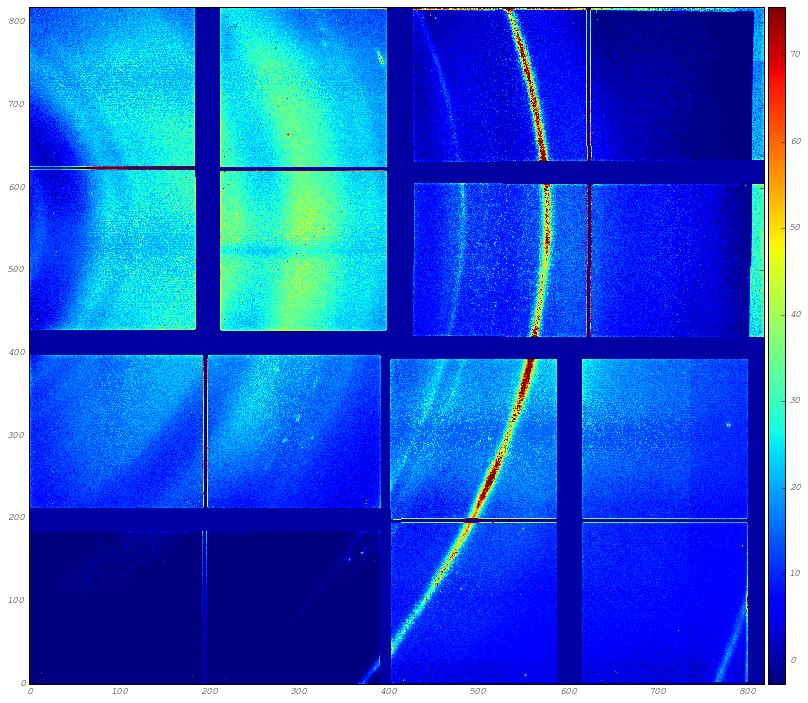

[array([[ -11.41893896,  -12.46317603,  -10.85947463, ...,    0.        ,
            0.        ,    0.        ],
        [  -9.84485417,  -12.03941594,  -11.95685224, ...,    0.        ,
            0.        ,    0.        ],
        [ -14.33461361,  -11.7642627 ,  -13.00255571, ...,    0.        ,
            0.        ,    0.        ],
        ..., 
        [  66.81695907,   57.51578008,   49.28717944, ...,   20.71846019,
           15.58878575,    0.        ],
        [ 121.4030954 ,   96.05131996,   88.90607063, ...,   24.35132231,
           18.33639773,    0.        ],
        [  -5.37945645,  218.92946767,  176.23481673, ...,    0.        ,
            0.        ,    0.        ]])]

In [9]:
datashow.main(['921'], 'quad2')


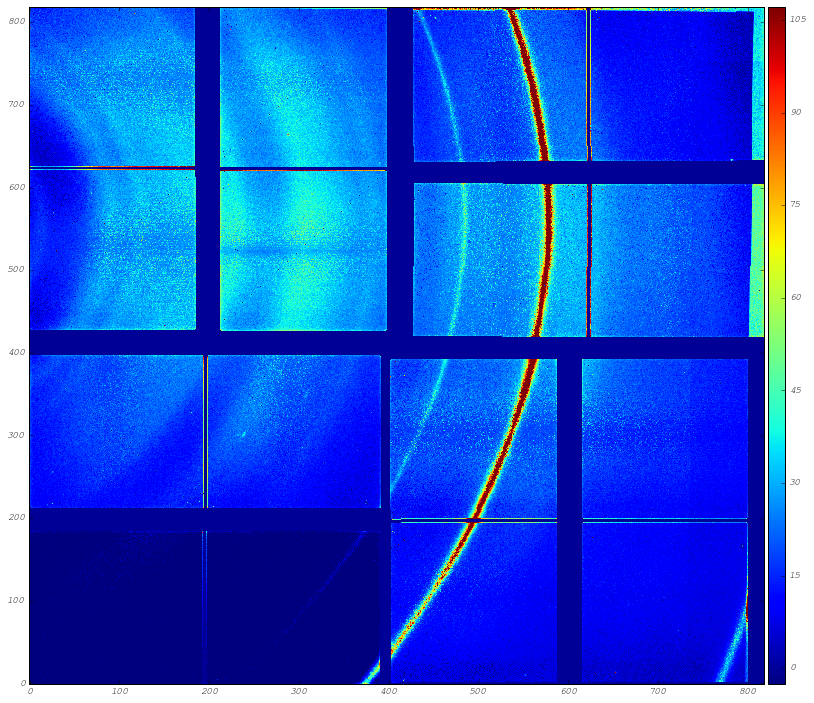

[array([[ -11.9650058 ,  -13.24487504,  -12.83082871, ...,    0.        ,
            0.        ,    0.        ],
        [ -12.38517394,  -12.76651728,  -12.56039037, ...,    0.        ,
            0.        ,    0.        ],
        [ -14.36056546,  -14.29308813,  -13.86758793, ...,    0.        ,
            0.        ,    0.        ],
        ..., 
        [  80.99203176,   65.42935821,   64.92776954, ...,   38.5624165 ,
           31.42412113,    0.        ],
        [ 150.72184576,  105.64018575,   99.29091659, ...,   46.40504812,
           36.26081341,    0.        ],
        [  -5.90840676,  262.80282435,  209.49034939, ...,    0.        ,
            0.        ,    0.        ]])]

In [10]:
datashow.main(['918'], 'quad2')


### 58 um dataset breakdown

In [4]:
r923 = query.DataSet([923], label = 'r923')
r922 = query.DataSet([922], label = 'r922')

In [32]:
_ = i220_i0_correlation_scatter(r923) 

[('slope', -0.0036573457309175984), ('intercept', 284.64802462282711), ('r_value', -0.013028008950729428), ('p_value', 0.8086482697487043), ('std_err', 0.015090827659398171)]


In [35]:
_ = i220_i0_correlation_scatter(r922)

[('slope', 2.1555959240061564e-06), ('intercept', -0.64081065255866321), ('r_value', 0.35634357280136714), ('p_value', 7.3985382798444902e-12), ('std_err', 3.0385912737017746e-07)]


In [ ]:
process_frame8

In [12]:
_ = i220_i0_correlation_scatter(r922, frame_processor=process_frame8)

[('slope', 0.00011817045252803454), ('intercept', 244.48406221492019), ('r_value', 0.38452550972519473), ('p_value', 1.0438820532182695e-13), ('std_err', 1.5251101181923148e-05)]
